In [21]:
bond_dim=24
iLayer=30

filename1='./data/X{0}/hotrg_gilt_X{0}.pth'.format(bond_dim)
filename2='./data/X{0}/hotrg_gilt_X{0}_lTRG_gilt_L{1}.pth'.format(bond_dim,iLayer)
filename_lattice='./data/X{0}/hotrg_gilt_X{0}_lTRG_gilt_L{1}_lattice.pth'.format(bond_dim,iLayer)
filename_prefix_figures='./data/X{0}/hotrg_gilt_X{0}_cyl_L{1}_'.format(bond_dim,iLayer)

# filename1='./data/hotrg_X24.pth'
# filename2='./data/hotrg_X24_lTRG_L20.pth'


In [22]:
from opt_einsum import contract
import torch
torch.set_default_tensor_type(torch.cuda.DoubleTensor)
device=torch.device('cuda:0')
torch.cuda.set_device(device)
import numpy as np
from ScalingDimensions import get_scaling_dimensions
from HOTRGZ2 import forward_observable_tensors, forward_layer
from TNModels import Ising2D
from tqdm.auto import tqdm
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.colors import hsv_to_rgb

In [23]:
print('loading coarse-grained tensors...')

options,params,layers,Ts,logTotals=torch.load(filename1,map_location=device)
T0_op,checkerboard=Ising2D(params).get_observables()['magnetization']

def forward_sigmas(positions):
    T_op=forward_observable_tensors(Ts[0],[T0_op]*len(positions),positions,layers[:20],checkerboard=checkerboard,cached_Ts=Ts,user_tqdm=False)[1]
    #T_op=T_op/T_op.norm()
    return T_op

print('done')


loading coarse-grained tensors...
done


In [24]:
T=Ts[iLayer]
M=contract('iIab,jJba->ijIJ',T,T).reshape(bond_dim**2,bond_dim**2)
s_cyl,u_cyl=torch.linalg.eig(M)# M=u*s@u.t().conj()
assert torch.isclose(M.cdouble()@u_cyl,u_cyl*s_cyl).all()
assert torch.isclose(u_cyl[:,:32].imag,torch.tensor(0.)).all()
assert torch.isclose(s_cyl.imag,torch.tensor(0.)).all()
u_cyl=u_cyl.real
s_cyl=s_cyl.real.abs()

scd_cyl=get_scaling_dimensions(s_cyl,scaling=np.exp(2*np.pi/2))
scd_cyl=[f'{x:.3f}' for x in scd_cyl]
print(scd_cyl[:64])

['0.000', '0.126', '1.012', '1.140', '1.139', '2.038', '2.035', '2.043', '2.036', '2.161', '2.183', '2.190', '3.015', '3.055', '3.115', '3.114', '3.136', '3.131', '3.185', '3.214', '3.213', '3.242', '3.297', '3.329', '3.517', '3.508', '3.662', '3.698', '3.814', '3.913', '3.931', '4.055', '3.995', '3.997', '4.110', '4.129', '4.159', '4.184', '4.188', '4.235', '4.216', '4.315', '4.259', '4.308', '4.319', '4.346', '4.367', '4.367', '4.494', '4.428', '4.406', '4.530', '4.435', '4.455', '4.474', '4.512', '4.474', '4.469', '4.563', '4.601', '4.583', '4.576', '4.706', '4.637']


In [25]:
def apply_to_state_cyl(T1,T2,v):
    v_op=contract('iIab,jJba,IJ->ij',T1,T2,v.reshape(24,24)).flatten()
    v_op=v_op/v_op.norm()
    return v_op

def apply_to_vacuum_cyl(T1,T2):
    return apply_to_state_cyl(T1,T2,u_cyl[:,0])

data=[]
for x in tqdm(np.linspace(0,1,81)):
    intx=int(x*(2**11-1))
    T_op=forward_sigmas([(0,intx%2**10)])
    if intx>=2**10:
        v_op=apply_to_vacuum_cyl(T,T_op)
    else:
        v_op=apply_to_vacuum_cyl(T_op,T)
    overlap=torch.real(u_cyl.T.conj()@v_op)
    #overlap=overlap/overlap.norm()
    data.append({'x':x,'overlap':overlap.cpu().numpy()})

  0%|          | 0/81 [00:00<?, ?it/s]

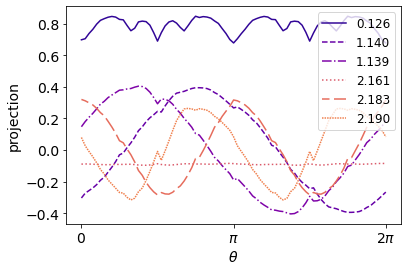

In [34]:
curve=pd.DataFrame(data)
overlaps=np.array(curve['overlap'].tolist())
plt.rcParams.update({'font.size': 14,'legend.fontsize':12})
plt.figure(figsize=(6,4))
cm=plt.get_cmap('plasma')
linestyles=['-','--','-.',':',(5, (10,3)),(0, (1, .7))]
iLinestyle=0
for i in range(16):
    overlap=overlaps[:,i]#/overlaps[:,1]
    if np.linalg.norm(overlap)>1e-6:
        plt.plot(curve['x']*2*np.pi,overlap,label=scd_cyl[i],color=cm(i/16),linestyle=linestyles[iLinestyle])
        iLinestyle=(iLinestyle+1)%len(linestyles)
plt.legend()
# plt.title(r'$\langle{O_i}|tr(T T)_{\sigma(r_0,\theta)}|0\rangle$')
plt.xlabel(r'$\theta$')
plt.xticks([0,np.pi,2*np.pi],[r'$0$',r'$\pi$',r'$2\pi$'])
plt.ylabel('projection')

plt.show()

In [ ]:
def show_overlap_cyl(v_op):
    plt.figure(figsize=(6,2))
    overlap=torch.real(u_cyl.T.conj()@v_op)
    plt.bar(range(32),(overlap[:32]).cpu().numpy())
    plt.xticks(range(32),scd_cyl[:32],rotation=75)


T,T_op,logTotal=forward_observable_tensors(Ts[0],[T0_op],[(2**9-1,0)],layers[:20],checkerboard=checkerboard,cached_Ts=Ts)
show_overlap_cyl(apply_to_vacuum_cyl(ltrg_operators['id'],T));plt.title('id,T|0>')
show_overlap_cyl(apply_to_vacuum_cyl(ltrg_operators['eps'],T));plt.title('eps,T|0>')
show_overlap_cyl(apply_to_vacuum_cyl(ltrg_operators['sig'],T));plt.title('sig,T|0>')
show_overlap_cyl(apply_to_vacuum_cyl(ltrg_operators['dx_sig'],T));plt.title('dx_sig,T|0>')
show_overlap_cyl(apply_to_vacuum_cyl(ltrg_operators['dxx_sig'],T));plt.title('dxx_sig,T|0>')


  0%|          | 0/20 [00:00<?, ?it/s]

RuntimeError: expected scalar type Double but found ComplexDouble

# trash code

In [ ]:
assert False, 'stop here'

In [5]:
print('loading lTRG eigenvectors...')

options1,s_ltrg,u_ltrg=torch.load(filename2,map_location=device)
# if not torch.isclose(u_ltrg[:,:12].imag,torch.tensor(0.)).all():
#     print('Warning: u_ltrg[:,:12] is not real',torch.max(u_ltrg[:,:12].imag).cpu().item())
# u_ltrg=u_ltrg.real
#u_ltrg_backup=u_ltrg.clone()
# for i in range(0,u_ltrg.shape[1]):
#     for j in range(0,i):
#         u_ltrg[:,i]=u_ltrg[:,i]-u_ltrg[:,j]@u_ltrg[:,i]*u_ltrg[:,j]
#     u_ltrg[:,i]=u_ltrg[:,i]/u_ltrg[:,i].norm()
#assert torch.isclose(u_ltrg[:,:12],u_ltrg_backup[:,:12]).all()

scd_ltrg=get_scaling_dimensions(s_ltrg.abs(),scaling=2)
scd_ltrg_labels=[f'{x:.3f}' for x in scd_ltrg]
print('Scaling Dimensions:',scd_ltrg[:64].cpu().numpy())
# print(s_ltrg.angle())

fprint('Scaling Dimensions:',scd_ltrg[:64].cpu().numpy())


u_ltrg_inv=torch.linalg.pinv(u_ltrg).T.conj()

# orthogonalize u_ltrg
u_ltrg_orth=u_ltrg.clone()
for i in range(0,u_ltrg.shape[1]):
    for j in range(0,i):
        u_ltrg_orth[:,i]=u_ltrg_orth[:,i]-u_ltrg_orth[:,j]@u_ltrg_orth[:,i]*u_ltrg_orth[:,j]

u_ltrg_useit_dualbasis=u_ltrg_inv
u_ltrg_useit_basis=u_ltrg

loading lTRG eigenvectors...
Scaling Dimensions: [0.         0.12786158 1.00240081 1.12631316 1.1442199  1.99835949
 2.00112256 2.00374206 2.04414052 2.11870437 2.19592101 2.20346481
 2.49777977 2.67394123 2.69240288 2.78475444 2.79882111 2.82348156
 2.84501301 2.84501301 3.02703124 3.0945276  3.09662916 3.09662916
 3.11682589 3.11682589 3.16167815 3.16167815 3.19633995 3.19633995
 3.20241642 3.21486398]


In [6]:
def project_out(T,Ys):
    for Y in Ys:
        T=T-contract('ijkl,ijkl->',T,Y)*Y/contract('ijkl,ijkl->',Y,Y)
    return T/T.norm()

def show_overlap_ltrg(v_op,title='',ax=None,k=32):
    if ax is None:
        plt.figure(figsize=(6,2))
    else:
        plt.sca(ax)
    plt.title(title)
    v_op=v_op.flatten().to(torch.complex128)
    #overlap=u_ltrg_inv.T.conj()@v_op
    #overlap=u_ltrg.T.conj()@v_op
    overlap=u_ltrg_useit_dualbasis.T.conj()@v_op
    barHeight=overlap.abs().cpu().numpy()
    barAngle=np.angle(overlap.cpu().numpy())
    barSign=np.sign(overlap.real.cpu().numpy())
    plt.bar(range(k),barHeight[:k],color=.7*plt.cm.hsv(barAngle[:k]/(2*np.pi)))
    plt.xticks(range(k),scd_ltrg_labels[:k],rotation=75)
    plt.axhline(0,color='k')

# Lattice Operators

In [6]:
# define the lattice operators
def get_lattice_operators():
    scan=[511-200,511-100,512+100,512+200]
    scan1=[50,100,200]
    id=project_out(forward_sigmas([]),[])
    id=id/id.norm()
    sig_raw=0
    for x in scan:
        for y in scan:
            sig_raw+=forward_sigmas([(x,y)])
    sig=project_out(sig_raw,[id])
    sig=sig/sig.norm()

    sigsig_raw,sigsigsig_raw,eps,dx_sig,dy_sig,dxx_sig,dyy_sig=0,0,0,0,0,0,0
    for x in scan:
        for dx in scan1:
            L,R=511-dx,512+dx
            ML,MR=511-dx+dx//5,512+dx-dx//5
            # eps+=project_out(forward_sigmas([(x,L),(x,R)]),[id])
            # eps+=project_out(forward_sigmas([(L,x),(R,x)]),[id])
            sigsig_raw+=forward_sigmas([(x,L),(x,R)])
            sigsig_raw+=forward_sigmas([(L,x),(R,x)])
            for M in [511,512]:
                sigsigsig_raw+=forward_sigmas([(x,ML),(x,M),(x,MR)])
                sigsigsig_raw+=forward_sigmas([(ML,x),(M,x),(MR,x)])
            dx_sig+=project_out(forward_sigmas([(R,x)])-forward_sigmas([(L,x)]),[sig])
            dy_sig+=project_out(forward_sigmas([(x,R)])-forward_sigmas([(x,L)]),[sig])
            dxx_sig+=project_out(forward_sigmas([(R,x)])-forward_sigmas([(MR,x)])-forward_sigmas([(ML,x)])+forward_sigmas([(L,x)]),[sig])
            dyy_sig+=project_out(forward_sigmas([(x,R)])-forward_sigmas([(x,MR)])-forward_sigmas([(x,ML)])+forward_sigmas([(x,L)]),[sig])
    eps=project_out(sigsig_raw,[id])
    eps=eps/eps.norm()
    Tplus,Tcross,dx_eps,dy_eps,dxy_sig=0,0,0,0,0
    for dx in scan1:
        L,R=511-dx,512+dx
        Tcross+=project_out(forward_sigmas([(R,R),(L,L)])-forward_sigmas([(L,R),(R,L)]),[id,eps])
        dx_eps+=project_out(forward_sigmas([(R,L),(R,R)])-forward_sigmas([(L,L),(L,R)]),[id])
        dy_eps+=project_out(forward_sigmas([(L,R),(R,R)])-forward_sigmas([(L,L),(R,L)]),[id])
        dxy_sig+=project_out(forward_sigmas([(R,R)])-forward_sigmas([(R,L)])-forward_sigmas([(L,R)])+forward_sigmas([(L,L)]),[sig])
        for M in [511,512]:
            Tplus+=project_out(forward_sigmas([(R,M),(L,M)])-forward_sigmas([(M,L),(M,R)]),[id,eps])
        
    rtval={'id':id,'sig':sig,'eps':eps,'dx_sig':dx_sig,'dy_sig':dy_sig,'dx_eps':dx_eps,'dy_eps':dy_eps,'Tplus':Tplus,'Tcross':Tcross,'dxx_sig':dxx_sig,'dyy_sig':dyy_sig,'dxy_sig':dxy_sig,
           'sig_raw':sig_raw,'sigsig_raw':sigsig_raw,'sigsigsig_raw':sigsigsig_raw}
    for op in rtval:
        rtval[op]=rtval[op]/rtval[op].norm()
    return rtval
lattice_operators=get_lattice_operators()
torch.save(lattice_operators,filename_lattice)

In [7]:

op_latex={
    'id':r'$\mathbb{1}$',
    'sig':r'$\sigma$',
    'eps':r'$\epsilon$',
    'dx_sig':r'$\partial_x\sigma$',
    'dy_sig':r'$\partial_y\sigma$',
    'dx_eps':r'$\partial_x\epsilon$',
    'dy_eps':r'$\partial_y\epsilon$',
    'Tplus':r'$T_+$',
    'Tcross':r'$T_{\times}$',
    'dxx_sig':r'$\partial_{x}^2\sigma$',
    'dyy_sig':r'$\partial_{y}^2\sigma$',
    'dxy_sig':r'$\partial_{x}\partial_{y}\sigma$',
}

lattice_operators=torch.load(filename_lattice, map_location=device)

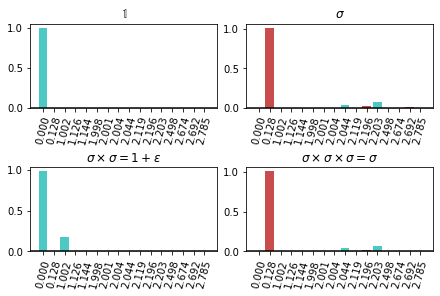

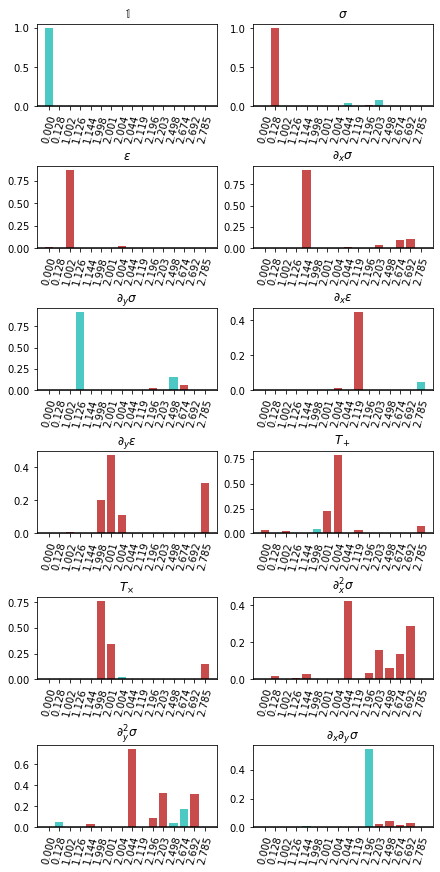

In [8]:
def show_NPT_projections(filename=None):

    # sig=forward_sigmas([(M,M)])
    # sigsig=forward_sigmas([(M,L),(M,R)])
    # sigsigsig=forward_sigmas([(M,L),(M,M),(M,R)])

    fig, axes = plt.subplots(2,2, constrained_layout=True,figsize=(6,4))
    show_overlap_ltrg(lattice_operators['id'],title=r'$\mathbb{1}$',ax=axes[0,0],k=16)
    show_overlap_ltrg(lattice_operators['sig_raw'],title=r'$\sigma$',ax=axes[0,1],k=16)
    show_overlap_ltrg(lattice_operators['sigsig_raw'],title=r'$\sigma\times\sigma=1+\epsilon$',ax=axes[1,0],k=16)
    show_overlap_ltrg(lattice_operators['sigsigsig_raw'],title=r'$\sigma\times\sigma\times\sigma=\sigma$',ax=axes[1,1],k=16)
    if filename is not None:
        plt.savefig(filename)
    plt.show()
show_NPT_projections(filename_prefix_figures+'NPT_projections.png')

def show_lattice_operator_projections(filename=None):
    fig, axes = plt.subplots(6,2, constrained_layout=True,figsize=(6,12))
    for i,op in enumerate(op_latex.keys()):
        show_overlap_ltrg(lattice_operators[op],title=op_latex[op],ax=axes[i//2,i%2],k=16)
    if filename is not None:
        plt.savefig(filename)
    plt.show()
show_lattice_operator_projections(filename_prefix_figures+'lattice_operator_projections.png')


# Rotate the basis

ul.shape torch.Size([331776, 12])
u_ltrg_useit_dualbasis.shape torch.Size([331776, 32])


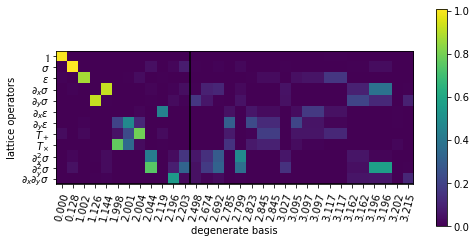

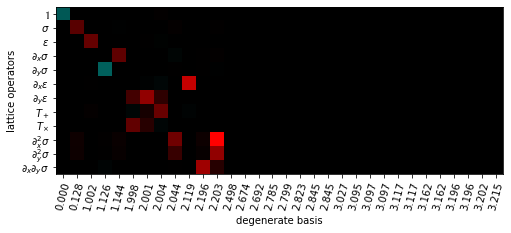

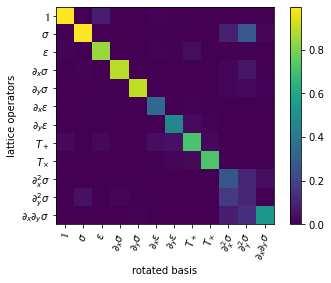

In [9]:
# rotate the degenerate basis to the basis of the lattice operators

def imshow_complex(arr,log=False):
    amp=np.log(np.abs(arr)) if log else np.abs(arr)
    amp=amp/amp.flatten().max()
    color=plt.cm.hsv(np.angle(arr)/(2*np.pi))*np.stack([amp,amp,amp,np.ones_like(amp)],axis=-1)
    plt.imshow(color)

def get_ltrg_operators(lattice_operators):
    ul=torch.stack([(T/T.norm()).flatten() for k,T in lattice_operators.items() if '_raw' not in k]).T.to(torch.complex128)
    print("ul.shape",ul.shape)
    print("u_ltrg_useit_dualbasis.shape",u_ltrg_useit_dualbasis.shape)
    gram=ul.T.conj()@u_ltrg_useit_dualbasis

    
    #rg1,rg2=[0,1,2,3,5,32],[0,1,2,3,5,12]
    #rg1,rg2=[0,1,2,3,5,9,12],[0,1,2,3,5,9,12]
    rg1,rg2=[0,12],[0,12]
    
    plt.figure(figsize=(8,4))
    plt.imshow(gram.abs().cpu().numpy())
    for i in range(len(rg1)-1):
        plt.axvline(rg1[i+1]-0.5,color='k')
        plt.axhline(rg2[i+1]-0.5,color='k')
    plt.colorbar()
    labels=[op_latex[k] for k in op_latex.keys()]
    plt.yticks(range(gram.shape[0]),labels)
    plt.xticks(range(gram.shape[1]),scd_ltrg_labels[:gram.shape[1]],rotation=75)
    plt.ylabel('lattice operators')
    plt.xlabel('degenerate basis')
    plt.show()

    rot=torch.zeros(gram.shape[1],gram.shape[0],dtype=torch.complex128)
    for i in range(len(rg1)-1):
        rot[rg2[i]:rg2[i+1],rg1[i]:rg1[i+1]]=torch.linalg.pinv(gram[rg1[i]:rg1[i+1],rg2[i]:rg2[i+1]])
    
    plt.figure(figsize=(8,4))
    imshow_complex(rot.T.cpu().numpy())
    #plt.imshow(rot.T.abs().cpu().numpy())
    #plt.colorbar()
    plt.yticks(range(gram.shape[0]),labels)
    plt.xticks(range(gram.shape[1]),scd_ltrg_labels[:gram.shape[1]],rotation=75)
    plt.ylabel('lattice operators')
    plt.xlabel('degenerate basis')
    plt.show()

    ur1=u_ltrg_useit_basis@rot

    for i in range(ur1.shape[1]):
        ur1[:,i]=ur1[:,i]/ur1[:,i].norm()

    plt.imshow((ul.T.conj()@ur1).abs().cpu().numpy())
    plt.colorbar()
    plt.yticks(range(gram.shape[0]),labels)
    plt.xticks(range(gram.shape[0]),labels,rotation=75)
    plt.ylabel('lattice operators')
    plt.xlabel('rotated basis')
    plt.show()


    return {k:(ur1[:,i]).reshape(bond_dim,bond_dim,bond_dim,bond_dim) for i,k in enumerate(op_latex.keys())}

ltrg_operators=get_ltrg_operators(lattice_operators)

# fusion of lTRG eigvecs

In [10]:



layers_sel=layers[20:22]
def CG(A,B,C,D):
    AB=forward_layer(A,B,layers_sel[0])
    CD=forward_layer(C,D,layers_sel[0])
    ABCD=forward_layer(AB,CD,layers_sel[1])
    return ABCD

def IP(A,B):
    return (A*B).sum().detach().cpu().item()

# renormalize of idop

idop=u_ltrg_useit_basis[:,0].reshape(bond_dim,bond_dim,bond_dim,bond_dim)
assert idop.imag.abs().max()<1e-10; idop=idop.real
idop=idop*(CG(idop,idop,idop,idop).norm()/idop.norm())**(-1/3)

# # verify with lTRG coroutines
# from linearized import get_linearized_HOTRG_autodiff
# from scipy.sparse.linalg import eigs
# M=get_linearized_HOTRG_autodiff(idop,layers_sel)
# eigvals,_=eigs(M,k=3,which='LR')
# eigvals=eigvals.real
# print(eigvals)
# print(eigvals/eigvals[0])
# print('scaling dimensions',-np.log2(eigvals/eigvals[0]))

idop_conj=u_ltrg_useit_dualbasis[:,0].reshape(bond_dim,bond_dim,bond_dim,bond_dim)
assert idop_conj.imag.abs().max()<1e-10; idop_conj=idop_conj.real
idop_conj=idop_conj/IP(idop_conj,idop)



print('|||idididid>||/|||id>|| is renormalized to',CG(idop,idop,idop,idop).norm()/idop.norm())

|||idididid>||/|||id>|| is renormalized to tensor(1.0000)


In [11]:
# load the other ltrg eigvecs

sig=u_ltrg_useit_basis[:,1].reshape(bond_dim,bond_dim,bond_dim,bond_dim)
eps=u_ltrg_useit_basis[:,2].reshape(bond_dim,bond_dim,bond_dim,bond_dim)
sig_conj=u_ltrg_useit_dualbasis[:,1].reshape(bond_dim,bond_dim,bond_dim,bond_dim)
eps_conj=u_ltrg_useit_dualbasis[:,2].reshape(bond_dim,bond_dim,bond_dim,bond_dim)

delta_sig=scd_ltrg[1].real.item()
delta_eps=scd_ltrg[2].real.item()
# delta_sig=0.125
# delta_eps=1

print('Δsig (eigenvalues) =',delta_sig)
print('Δeps (eigenvalues) =',delta_eps)
fprint('Δsig (eigenvalues) =',delta_sig)
fprint('Δeps (eigenvalues) =',delta_eps)

assert sig.imag.abs().max()<1e-10; sig=sig.real
assert eps.imag.abs().max()<1e-10; eps=eps.real
assert sig_conj.imag.abs().max()<1e-10; sig_conj=sig_conj.real
assert eps_conj.imag.abs().max()<1e-10; eps_conj=eps_conj.real


def shuffle_operator_positions_1pt(idop,op):
    positions=[(0,0),(0,1),(1,0),(1,1)]
    for i in range(4):
        ops=[op if k==i else idop for k in range(4)]
        pos=positions[i]
        yield ops,pos

# check the scaling dimensions of sig, eps
vals=[]
for ops,pos in shuffle_operator_positions_1pt(idop,sig):
    val=IP(sig_conj,CG(*ops))
    print(f'2^Δsig <sig|sig{pos}> =',2**delta_sig*val)
    vals.append(val)
delta_sig=np.log2(1/np.abs(np.mean(vals)))
print('Δsig (coarse graining) =',delta_sig)
fprint('Δsig (coarse graining) =',delta_sig)

vals=[]
for ops,pos in shuffle_operator_positions_1pt(idop,eps):
    val=IP(eps_conj,CG(*ops))
    print(f'2^Δeps <eps|eps{pos}> =',2**delta_eps*val)
    vals.append(val)
delta_eps=np.log2(1/np.abs(np.mean(vals)))
print('Δeps (coarse graining) =',delta_eps)
fprint('Δeps (coarse graining) =',delta_eps)

Δsig (eigenvalues) = 0.12786157938980222
Δeps (eigenvalues) = 1.0024008079065978
2^Δsig <sig|sig(0, 0)> = 0.9990473706709004
2^Δsig <sig|sig(0, 1)> = 1.00042333908558
2^Δsig <sig|sig(1, 0)> = 0.9989760423544536
2^Δsig <sig|sig(1, 1)> = 1.0009453094502898
Δsig (coarse graining) = 0.1280808634968262
2^Δeps <eps|eps(0, 0)> = -0.9999229709466365
2^Δeps <eps|eps(0, 1)> = -1.0013767737618822
2^Δeps <eps|eps(1, 0)> = -0.9979851841159532
2^Δeps <eps|eps(1, 1)> = -1.0009647401056354
Δeps (coarse graining) = 1.002310761684954


In [12]:
def shuffle_operator_positions_2pt(idop,op):
    positions=[(0,0),(0,1),(1,0),(1,1)]
    for i in range(4):
        for j in range(i+1,4):
            ops=[op if k==i or k==j else idop for k in range(4)]
            pos1,pos2=positions[i],positions[j]
            yield ops,pos1,pos2

def shuffle_operator_positions_2pt_asym(idop,op1,op2):
    positions=[(0,0),(0,1),(1,0),(1,1)]
    for i in range(4):
        for j in range(4):
            if i==j: continue
            ops=[idop]*4
            ops[i]=op1
            ops[j]=op2
            pos1,pos2=positions[i],positions[j]
            yield ops,pos1,pos2

# renormalization of sig with lattice_spacing renormalized to 1
# |O(r1)O(r2)>=C_{OOid}/r12*(2*delta_O) |O(0)> + ...
# C_{OOid} should be renormalized to 1
vals=[]#IP(idop_conj,CG(sig,sig,idop,idop))
for ops,pos1,pos2 in shuffle_operator_positions_2pt(idop,sig):
    dist=((pos1[0]-pos2[0])**2+(pos1[1]-pos2[1])**2)**.5
    val=IP(idop_conj,CG(*ops))*dist**(2*delta_sig)
    vals.append(val)
print(vals)
sig=sig*np.abs(np.average(vals))**(-1/2)
vals=[]
for ops,pos in shuffle_operator_positions_1pt(idop,sig):
    val=IP(sig_conj,CG(*ops))
    vals.append(val)
sig_conj=sig_conj/np.average(vals)

# renormalization of eps
vals=[]#IP(idop_conj,CG(eps,eps,idop,idop))
for ops,pos1,pos2 in shuffle_operator_positions_2pt(idop,eps):
    dist=((pos1[0]-pos2[0])**2+(pos1[1]-pos2[1])**2)**.5
    val=IP(idop_conj,CG(*ops))*dist**(2*delta_eps)
    vals.append(val)
print(vals)
eps=eps*np.abs(np.average(vals))**(-1/2)
vals=[]
for ops,pos in shuffle_operator_positions_1pt(idop,eps):
    val=IP(eps_conj,CG(*ops))
    vals.append(val)
eps_conj=eps_conj/np.average(vals)


print('C_sigsigid',1)
vals=[]
for ops,pos1,pos2 in shuffle_operator_positions_2pt(idop,sig):
    dist=((pos1[0]-pos2[0])**2+(pos1[1]-pos2[1])**2)**.5
    val=IP(idop_conj,CG(*ops))*dist**(2*delta_sig)
    print(f'r^(2 delta) <id|sig{pos1}sig{pos2}>=',val)
    vals.append(val)
print('average',np.average(vals))
fprint('C_sigsigid',np.average(vals))

print('C_epsepsid',1)
vals=[]
for ops,pos1,pos2 in shuffle_operator_positions_2pt(idop,eps):
    dist=((pos1[0]-pos2[0])**2+(pos1[1]-pos2[1])**2)**.5
    val=IP(idop_conj,CG(*ops))*dist**(2*delta_eps)
    print(f'r^(2 delta) <id|eps{pos1}eps{pos2}>=',val)
    vals.append(val)
print('average',np.average(vals))
fprint('C_epsepsid',np.average(vals))



print('C_sigsigsig',0)
vals=[]
for ops,pos1,pos2 in shuffle_operator_positions_2pt(idop,sig):
    dist=((pos1[0]-pos2[0])**2+(pos1[1]-pos2[1])**2)**.5
    delta=delta_sig+delta_sig-delta_sig
    val=IP(sig_conj,CG(*ops))*dist**delta
    print(f'r^(Δ+Δ-Δ) <sig|sig{pos1}sig{pos2}>=',val)
    vals.append(val)
print('average',np.average(vals))
fprint('C_sigsigsig',np.average(vals))

print('C_sigsigeps',0.5)
vals=[]
for ops,pos1,pos2 in shuffle_operator_positions_2pt(idop,sig):
    dist=((pos1[0]-pos2[0])**2+(pos1[1]-pos2[1])**2)**.5
    delta=delta_sig+delta_sig-delta_eps
    val=IP(eps_conj,CG(*ops))*dist**delta
    print(f'r^(Δ+Δ-Δ) <eps|sig{pos1}sig{pos2}>=',val)
    vals.append(val)
print('average',np.average(vals))
fprint('C_sigsigeps',np.average(vals))

print('C_epsepssig',0)
vals=[]
for ops,pos1,pos2 in shuffle_operator_positions_2pt(idop,eps):
    dist=((pos1[0]-pos2[0])**2+(pos1[1]-pos2[1])**2)**.5
    delta=delta_eps+delta_eps-delta_sig
    val=IP(sig_conj,CG(*ops))*dist**delta
    print(f'r^(Δ+Δ-Δ) <sig|eps{pos1}eps{pos2}>=',val)
    vals.append(val)
print('average',np.average(vals))
fprint('C_epsepssig',np.average(vals))

print('C_epsepseps',0)
vals=[]
for ops,pos1,pos2 in shuffle_operator_positions_2pt(idop,eps):
    dist=((pos1[0]-pos2[0])**2+(pos1[1]-pos2[1])**2)**.5
    delta=delta_eps+delta_eps-delta_eps
    val=IP(eps_conj,CG(*ops))*dist**delta
    print(f'r^(Δ+Δ-Δ) <eps|eps{pos1}eps{pos2}>=',val)
    vals.append(val)
print('average',np.average(vals))
fprint('C_epsepseps',np.average(vals))

print('C_sigepssig',0.5)
vals=[]
for ops,pos1,pos2 in shuffle_operator_positions_2pt_asym(idop,sig,eps):
    dist=((pos1[0]-pos2[0])**2+(pos1[1]-pos2[1])**2)**.5
    delta=delta_sig+delta_eps-delta_sig
    val=IP(sig_conj,CG(*ops))*dist**delta
    print(f'r^(Δ+Δ-Δ) <sig|sig{pos1}eps{pos2}>=',val)
    vals.append(val)
print('average',np.average(vals))
fprint('C_sigepssig',np.average(vals))

print('C_sigepseps',0)
vals=[]
for ops,pos1,pos2 in shuffle_operator_positions_2pt_asym(idop,sig,eps):
    dist=((pos1[0]-pos2[0])**2+(pos1[1]-pos2[1])**2)**.5
    delta=delta_sig+delta_eps-delta_eps
    val=IP(eps_conj,CG(*ops))*dist**delta
    print(f'r^(Δ+Δ-Δ) <eps|sig{pos1}eps{pos2}>=',val)
    vals.append(val)
print('average',np.average(vals))
fprint('C_sigepseps',np.average(vals))




[-0.24976365130712225, -0.25321157150527046, -0.25148998630544533, -0.25150323512915246, -0.2528680372754063, -0.2496201086117309]
[-0.10316664221100183, -0.09026105392749137, -0.08323736125757557, -0.08321460896969697, -0.0900321905109854, -0.10306620135708498]
C_sigsigid 1
r^(2 delta) <id|sig(0, 0)sig(0, 1)>= -0.9934537842481007
r^(2 delta) <id|sig(0, 0)sig(1, 0)>= -1.0071681472096805
r^(2 delta) <id|sig(0, 0)sig(1, 1)>= -1.000320412069996
r^(2 delta) <id|sig(0, 1)sig(1, 0)>= -1.0003731102667897
r^(2 delta) <id|sig(0, 1)sig(1, 1)>= -1.0058017138680349
r^(2 delta) <id|sig(1, 0)sig(1, 1)>= -0.9928828323373976
average -0.9999999999999999
C_epsepsid 1
r^(2 delta) <id|eps(0, 0)eps(0, 1)>= -1.1193931550250722
r^(2 delta) <id|eps(0, 0)eps(1, 0)>= -0.9793631329508156
r^(2 delta) <id|eps(0, 0)eps(1, 1)>= -0.9031536787202209
r^(2 delta) <id|eps(0, 1)eps(1, 0)>= -0.9029068086586705
r^(2 delta) <id|eps(0, 1)eps(1, 1)>= -0.9768798870451437
r^(2 delta) <id|eps(1, 0)eps(1, 1)>= -1.1183033376000782


In [19]:
# # check for higher operators

ops=[u_ltrg_useit_basis[:,i].reshape(bond_dim,bond_dim,bond_dim,bond_dim).real for i in range(u_ltrg_useit_basis.shape[1])][:10]
ops={scd_ltrg[i].real.item():op/op.norm() for i,op in enumerate(ops)}

# for name,op in ops.items():
for name,op in ltrg_operators.items():
    op=op.real;op=op/op.norm()
    fuse1=np.max(np.abs([IP(idop_conj,CG(*ops)) for ops,pos1 in shuffle_operator_positions_1pt(idop,op)]))
    fuse2=np.max(np.abs([IP(idop_conj,CG(*ops)) for ops,pos1,pos2 in shuffle_operator_positions_2pt_asym(idop,sig,op)]))
    fuse3=np.max(np.abs([IP(idop_conj,CG(*ops)) for ops,pos1,pos2 in shuffle_operator_positions_2pt_asym(idop,eps,op)]))
    print(name)
    #print('id','{:.3f}'.format(fuse1),'sig','{:.3f}'.format(fuse2),'eps','{:.3f}'.format(fuse3))
    print('id','{:.3f}'.format(fuse1))
    print('sig','{:.3f}'.format(fuse2))
    print('eps','{:.3f}'.format(fuse3))
    print()




id
id 0.541
sig 0.000
eps 0.010

sig
id 0.000
sig 0.498
eps 0.000

eps
id 0.001
sig 0.000
eps 0.338

dx_sig
id 0.000
sig 0.174
eps 0.000

dy_sig
id 0.000
sig 0.164
eps 0.000

dx_eps
id 0.029
sig 0.000
eps 0.308

dy_eps
id 0.018
sig 0.000
eps 0.205

Tplus
id 0.002
sig 0.000
eps 0.030

Tcross
id 0.039
sig 0.000
eps 0.017

dxx_sig
id 0.000
sig 0.069
eps 0.000

dyy_sig
id 0.000
sig 0.086
eps 0.000

dxy_sig
id 0.000
sig 0.037
eps 0.000



# Encoding Position

In [ ]:

data=[]
for x in tqdm(np.linspace(0,1023,111)):
    for y in [511,512]:
        xint,yint=int(x),int(y)
        T_op=forward_sigmas([(xint,yint)])
        T_op=T_op/T_op.norm()
        row={'x':xint,'y':yint}
        for key,op in ltrg_operators.items():
            overlap=op.flatten().conj()@T_op.flatten().to(torch.complex128)
            overlap=overlap.abs()*overlap.real.sign()
            row[key]=overlap.detach().cpu().item()
        data.append(row)


  0%|          | 0/111 [00:00<?, ?it/s]

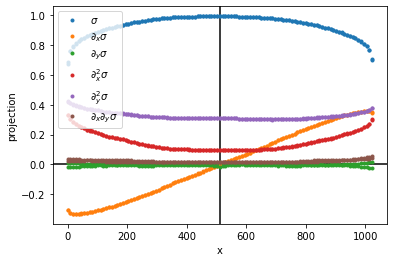

In [ ]:
curve=pd.DataFrame(data)

fittings={}
for i,key in enumerate(ltrg_operators.keys()):
    p=np.polyfit(curve['x'].values,curve[key].values,2)
    fittings[key]=p

plt.figure(figsize=(6,4))

plt.axhline(0,color='k')
plt.axvline(511.5,color='k')

for i,key in enumerate(ltrg_operators.keys()):
    normalized=curve[key]/curve['sig']
    normalized=curve[key]
    if(normalized.abs().max()>.01):
        # if key in fittings.keys():
        #     plt.plot(curve['x'],np.polyval(fittings[key],curve['x']),'-',color=plt.cm.rainbow(i/len(ltrg_operators)))
        
        plt.plot(curve['x'],curve[key],'.',label=op_latex[key])



plt.legend()
plt.xlabel('x')
plt.ylabel('projection')
#plt.title(r'projection of $\sigma(x)$ onto lattice operators')
plt.show()

In [ ]:
assert False

In [24]:
T=Ts[20]
M=contract('iIab,jJba->ijIJ',T,T).reshape(24**2,24**2)
s_cyl,u_cyl=torch.linalg.eig(M)# M=u*s@u.t().conj()
assert torch.isclose(M.cdouble()@u_cyl,u_cyl*s_cyl).all()
assert torch.isclose(u_cyl[:,:32].imag,torch.tensor(0.)).all()
assert torch.isclose(s_cyl.imag,torch.tensor(0.)).all()
u_cyl=u_cyl.real
s_cyl=s_cyl.real.abs()

scd_cyl=get_scaling_dimensions(s_cyl,scaling=np.exp(2*np.pi/2))
scd_cyl=[f'{x:.3f}' for x in scd_cyl]
print(scd_cyl[:64])

['0.000', '0.126', '1.009', '1.136', '1.136', '2.032', '2.029', '2.037', '2.029', '2.154', '2.176', '2.183', '3.008', '3.046', '3.104', '3.102', '3.120', '3.128', '3.175', '3.204', '3.203', '3.230', '3.287', '3.332', '3.518', '3.511', '3.676', '3.699', '3.816', '3.916', '3.949', '4.043', '3.993', '4.003', '4.100', '4.120', '4.149', '4.173', '4.176', '4.205', '4.246', '4.346', '4.247', '4.330', '4.305', '4.328', '4.354', '4.354', '4.535', '4.552', '4.422', '4.416', '4.456', '4.427', '4.443', '4.509', '4.470', '4.468', '4.546', '4.606', '4.579', '4.592', '4.727', '4.717']


In [25]:
def apply_to_state_cyl(T1,T2,v):
    v_op=contract('iIab,jJba,IJ->ij',T1,T2,v.reshape(24,24)).flatten()
    v_op=v_op/v_op.norm()
    return v_op

def apply_to_vacuum_cyl(T1,T2):
    return apply_to_state_cyl(T1,T2,u_cyl[:,0])

data=[]
for x in tqdm(np.linspace(0,1,41)):
    intx=int(x*(2**11-1))
    T_op=forward_sigmas([(0,intx%2**10)])
    if intx>=2**10:
        v_op=apply_to_vacuum_cyl(T,T_op)
    else:
        v_op=apply_to_vacuum_cyl(T_op,T)
    overlap=torch.real(u_cyl.T.conj()@v_op)
    #overlap=overlap/overlap.norm()
    data.append({'x':x,'overlap':overlap.cpu().numpy()})

  0%|          | 0/41 [00:00<?, ?it/s]

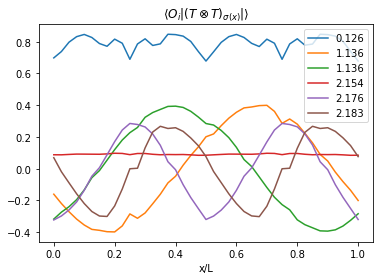

In [26]:
curve=pd.DataFrame(data)
overlaps=np.array(curve['overlap'].tolist())

for i in range(16):
    overlap=overlaps[:,i]#/overlaps[:,1]
    if np.linalg.norm(overlap)>1e-6:
        plt.plot(curve['x'],overlap,label=scd_cyl[i])
plt.legend()
plt.title(r'$\langle{O_i}|(T\otimes T)_{\sigma(x)}|\rangle$')
plt.xlabel('x/L')
plt.show()

In [27]:
def show_overlap_cyl(v_op):
    plt.figure(figsize=(6,2))
    overlap=torch.real(u_cyl.T.conj()@v_op)
    plt.bar(range(32),(overlap[:32]).cpu().numpy())
    plt.xticks(range(32),scd_cyl[:32],rotation=75)


T,T_op,logTotal=forward_observable_tensors(Ts[0],[T0_op],[(2**9-1,0)],layers[:20],checkerboard=checkerboard,cached_Ts=Ts)
show_overlap_cyl(apply_to_vacuum_cyl(ltrg_operators['id'],T));plt.title('id,T|0>')
show_overlap_cyl(apply_to_vacuum_cyl(ltrg_operators['eps'],T));plt.title('eps,T|0>')
show_overlap_cyl(apply_to_vacuum_cyl(ltrg_operators['sig'],T));plt.title('sig,T|0>')
show_overlap_cyl(apply_to_vacuum_cyl(ltrg_operators['dx_sig'],T));plt.title('dx_sig,T|0>')
show_overlap_cyl(apply_to_vacuum_cyl(ltrg_operators['dxx_sig'],T));plt.title('dxx_sig,T|0>')


  0%|          | 0/20 [00:00<?, ?it/s]

RuntimeError: expected scalar type Double but found ComplexDouble

In [ ]:
def fake_T_op(x):
    T_op=0
    for key in fittings.keys():
        T_op+=np.polyval(fittings[key],x)*ltrg_operators[key]
    return T_op

In [ ]:
data_ref=[]
for x in tqdm(np.linspace(0,1,41)):
    intx=int(x*(2**11-1))
    T_op=forward_sigmas([(0,intx%2**10)])
    if intx>=2**10:
        v_op=apply_to_vacuum_cyl(T,T_op)
    else:
        v_op=apply_to_vacuum_cyl(T_op,T)
    overlap=u_cyl.T.conj()@v_op
    data_ref.append({'x':x,
                 'overlap':overlap.cpu().numpy()
                 })

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

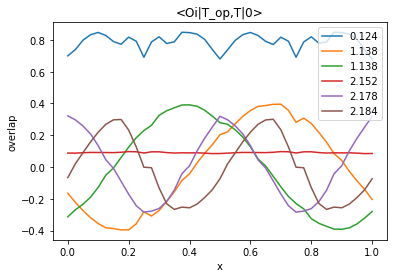

Text(0.5, 1.0, '<Oi|T_op_fake,T|0>')

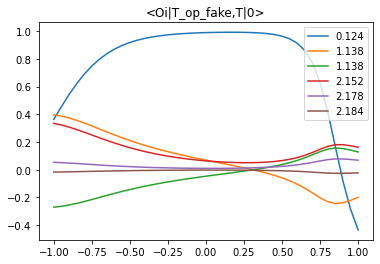

In [ ]:
data_fake=[]
for x in tqdm(np.linspace(-1,1,41)):
    T_op_fake=fake_T_op(x)
    v_op_fake=apply_to_vacuum_cyl(T,T_op_fake)
    overlap_fake=u_cyl.T.conj()@v_op_fake
    data_fake.append({'x':x,
                 'overlap_fake':overlap_fake.cpu().numpy()
                 })

curve_fake=pd.DataFrame(data_fake)
curve_ref=pd.DataFrame(data_ref)
overlaps=np.array(curve_ref['overlap'].tolist())
overlaps_fake=np.array(curve_fake['overlap_fake'].tolist())

for i in range(16):
    overlap=overlaps[:,i]#/overlaps[:,1]
    if np.linalg.norm(overlap)>1e-6:
        plt.plot(curve_ref['x'],overlap,label=scd_cyl[i])
plt.legend()
plt.title('<Oi|T_op,T|0>')
plt.xlabel('x')
plt.ylabel('overlap')
plt.show()

for i in range(16):
    overlap=overlaps_fake[:,i]#/overlaps_fake[:,1]
    if np.linalg.norm(overlap)>1e-6:
        plt.plot(curve_fake['x'],overlap,label=scd_cyl[i])
plt.legend()
plt.title('<Oi|T_op_fake,T|0>')

In [ ]:
# define the lattice operators
op_latex={
    'id':r'$\mathbb{1}$',
    'sig':r'$\sigma$',
    'eps':r'$\epsilon$',
    'dx_sig':r'$\partial_x\sigma$',
    'dy_sig':r'$\partial_y\sigma$',
    'dx_eps':r'$\partial_x\epsilon$',
    'dy_eps':r'$\partial_y\epsilon$',
    'Tplus':r'$T_+$',
    'Tcross':r'$T_{\times}$',
    'dxx_sig':r'$\partial_{x}^2\sigma$',
    'dyy_sig':r'$\partial_{y}^2\sigma$',
    'dxy_sig':r'$\partial_{x}\partial_{y}\sigma$',
}
def get_lattice_operators():
    scan=[511-200,511-100,512+100,512+200]
    scan1=[50,100,200]
    id=project_out(forward_sigmas([]),[])
    sig=0
    for x in scan:
        for y in scan:
            sig+=project_out(forward_sigmas([(x,y)]),[id])
    id=id/id.norm()
    sig=sig/sig.norm()
    eps,dx_sig,dy_sig,dxx_sig,dyy_sig=0,0,0,0,0
    for x in scan:
        for y in scan:
            for dx in scan1:
                L,R=y-dx,y+dx
                ML,MR=y-dx+dx//5,y+dx-dx//5
                eps+=project_out(forward_sigmas([(L,x),(R,x)]),[id])
                eps+=project_out(forward_sigmas([(x,L),(x,R)]),[id])
                dx_sig+=project_out(forward_sigmas([(R,x)])-forward_sigmas([(L,x)]),[sig])
                dy_sig+=project_out(forward_sigmas([(x,R)])-forward_sigmas([(x,L)]),[sig])
                dxx_sig+=project_out(forward_sigmas([(R,x)])-forward_sigmas([(MR,x)])-forward_sigmas([(ML,x)])+forward_sigmas([(L,x)]),[sig])
                dyy_sig+=project_out(forward_sigmas([(x,R)])-forward_sigmas([(x,MR)])-forward_sigmas([(x,ML)])+forward_sigmas([(x,L)]),[sig])
    eps=eps/eps.norm()
    Tplus,Tcross,dx_eps,dy_eps,dxy_sig=0,0,0,0,0
    for x in scan:
        for y in scan:
            for dx in scan1:
                Lx,Rx=x-dx,x+dx
                Ly,Ry=y-dx,y+dx
                Mx,My=x,y
                Tcross+=project_out(forward_sigmas([(Rx,Ry),(Lx,Ly)])-forward_sigmas([(Lx,Ry),(Rx,Ly)]),[id,eps])
                dx_eps+=project_out(forward_sigmas([(Rx,Ly),(Rx,Ry)])-forward_sigmas([(Lx,Ly),(Lx,Ry)]),[id])
                dy_eps+=project_out(forward_sigmas([(Lx,Ry),(Rx,Ry)])-forward_sigmas([(Lx,Ly),(Rx,Ly)]),[id])
                dxy_sig+=project_out(forward_sigmas([(Rx,Ry)])-forward_sigmas([(Rx,Ly)])-forward_sigmas([(Lx,Ry)])+forward_sigmas([(Lx,Ly)]),[sig])
                Tplus+=project_out(forward_sigmas([(Rx,My),(Lx,My)])-forward_sigmas([(Mx,Ly),(Mx,Ry)]),[id,eps])
                
    rtval={'id':id,'sig':sig,'eps':eps,'dx_sig':dx_sig,'dy_sig':dy_sig,'dx_eps':dx_eps,'dy_eps':dy_eps,'Tplus':Tplus,'Tcross':Tcross,'dxx_sig':dxx_sig,'dyy_sig':dyy_sig,'dxy_sig':dxy_sig}
    for op in rtval:
        rtval[op]=rtval[op]/rtval[op].norm()
    return rtval
lattice_operators=get_lattice_operators()



In [ ]:
def get_NPT_operators():
    scan=[511-400,511-200,512+200,512+400]
    scan1=[100,200,400]
    id=forward_sigmas([])
    sig,sigsig,sigsigsig=0,0,0
    for x in scan:
        for y in scan:
            sig+=forward_sigmas([(x,y)])
    for x in scan:
        for dx in scan1:
            L,R=511-dx,512+dx
            ML,MR=511-dx//2,512+dx//2
            sigsig+=forward_sigmas([(x,L),(x,R)])
            sigsig+=forward_sigmas([(L,x),(R,x)])
            for M in [511,512]:
                sigsigsig+=forward_sigmas([(x,ML),(x,M),(x,MR)])
                sigsigsig+=forward_sigmas([(ML,x),(M,x),(MR,x)])
    rtval={'id':id,'sig':sig,'sigsig':sigsig,'sigsigsig':sigsigsig}
    for k in rtval:
        rtval[k]=rtval[k]/rtval[k].norm()
    return rtval

NPT_operators=get_NPT_operators()